In [ ]:
###import
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pylab as plt
from scipy.stats import norm
import math
import seaborn as sns
import time

In [ ]:
df=pd.read_excel("/content/UNRATE.xlsx", sheet_name='Monthly')

In [ ]:
df

,observation_date,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
931,2025-08-01,4.3
932,2025-09-01,4.4
933,2025-10-01,NaN
934,2025-11-01,4.5


In [ ]:
df.rename(columns={"observation_date":"date","UNRATE":"unemployment_rate"}, inplace=True)
print(type(df.date[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [ ]:
##Check missing values in all columns
missing_values=df.isnull().sum()
print(missing_values)

date                 0
unemployment_rate    1
dtype: int64


In [ ]:
df = df.dropna(subset=['unemployment_rate'])
missing_values=df.isnull().sum()
print(missing_values)

date                 0
unemployment_rate    0
dtype: int64


In [ ]:
df

,date,unemployment_rate
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
930,2025-07-01,4.3
931,2025-08-01,4.3
932,2025-09-01,4.4
934,2025-11-01,4.5


In [ ]:
today = pd.Timestamp('2026-01-09')  # Adjust or use pd.Timestamp('now')

# Days since each observation (older = larger number)
df['days_ago'] = (today - df['date']).dt.days
df['days_ago'] = df['days_ago'].clip(lower=0)  # No negative days

# Exponential decay: weight = exp(-lambda * days_ago)
half_life = 365  # e.g., 1 year; adjust as needed
decay_lambda = np.log(2) / half_life
unemployment_weight= np.exp(-decay_lambda * df['days_ago'])

# Normalize to sum to 1
unemployment_weight /= (unemployment_weight.sum())

/tmp/ipython-input-2364252652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_ago'] = (today - df['date']).dt.days
/tmp/ipython-input-2364252652.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_ago'] = df['days_ago'].clip(lower=0)  # No negative days


In [ ]:
print(df['days_ago'])
print(unemployment_weight.sum())
print(unemployment_weight)

0      28498
1      28467
2      28438
3      28407
4      28377
       ...  
930      192
931      161
932      130
934       69
935       39
Name: days_ago, Length: 935, dtype: int64
1.0000000000000002
0      1.998004e-25
1      2.119158e-25
2      2.239138e-25
3      2.374913e-25
4      2.514143e-25
           ...     
930    4.422612e-02
931    4.690787e-02
932    4.975224e-02
934    5.586268e-02
935    5.913764e-02
Name: days_ago, Length: 935, dtype: float64


In [ ]:
loggrowth=np.log(df["unemployment_rate"]/(df["unemployment_rate"].shift(1)))
loggrowth
rate_change=loggrowth.dropna()
print(rate_change)

1      0.111226
2      0.051293
3     -0.025318
4     -0.108214
5      0.028171
         ...   
930    0.047628
931    0.000000
932    0.022990
934    0.022473
935   -0.022473
Name: unemployment_rate, Length: 934, dtype: float64


In [ ]:
#Function of weighted std和 mean:
def weighted_function(values, weights):
    values = np.array(values)
    weights = np.array(weights)

    if weights.sum() == 0:
        return np.nan

    weighted_mean = np.average(values, weights=weights)
    variance = np.average((values - weighted_mean)**2, weights=weights)
    return weighted_mean, np.sqrt(variance)

average_change, change_std = weighted_function(rate_change, unemployment_weight[0:934])
print(average_change)
print(change_std)

0.0035182329787543263
0.053273085719834495


In [ ]:
###Monte-Carlo Simulation settings
#randomize via normal ditribution
def shock(mean, std):
  return np.random.normal(mean, std)


#Return the result of running the one-time simulation，unemployment_rate after X months，generate random samples
def portfolio_pl(mean, std, months, initial_rate):
  esti_unemployment_rate=initial_rate

  for month in range(months):
    z_score=shock(mean, std)
    esti_unemployment_rate=esti_unemployment_rate * np.exp(mean + z_score * std)
  return esti_unemployment_rate

In [ ]:
###Running
months=3
initial_rate=df.unemployment_rate[df["date"] == "2025-12-01"]
simulation_times=300000
#load simulation results
simulation_result=[]
for i in range(simulation_times):
  pl=portfolio_pl(average_change, change_std, months, initial_rate)
  simulation_result.append(pl.iloc[0])

In [ ]:
simulation_result

[np.float64(4.408051540891524),
 np.float64(4.484690003569896),
 np.float64(4.445274398227511),
 np.float64(4.3945580636722985),
 np.float64(4.419735424431179),
 np.float64(4.460439188349854),
 np.float64(4.46941706750988),
 np.float64(4.434000844964695),
 np.float64(4.439097857258516),
 np.float64(4.463639233283134),
 np.float64(4.468855169487728),
 np.float64(4.499061425484415),
 np.float64(4.439621410765237),
 np.float64(4.500119521666537),
 np.float64(4.395791881324102),
 np.float64(4.458847376146314),
 np.float64(4.42258081803475),
 np.float64(4.461345476666788),
 np.float64(4.466213324056767),
 np.float64(4.453531991046546),
 np.float64(4.445628825335468),
 np.float64(4.459998870211596),
 np.float64(4.459361049758142),
 np.float64(4.458670616772652),
 np.float64(4.4589960804825655),
 np.float64(4.452356350131209),
 np.float64(4.433271361270319),
 np.float64(4.437823900231618),
 np.float64(4.486588721194848),
 np.float64(4.47321642089255),
 np.float64(4.473011447604397),
 np.float

4.42


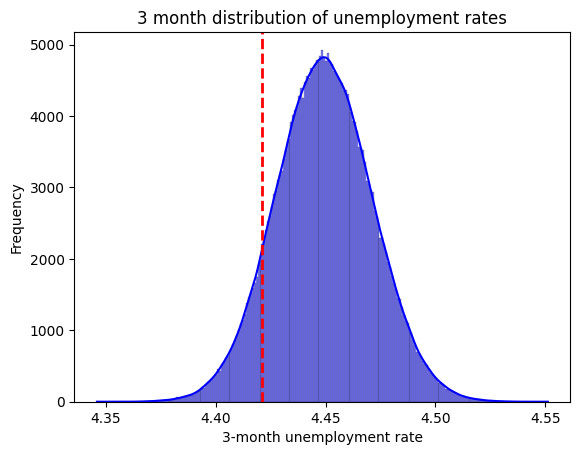

In [ ]:
#10% Forecast
Forecast_percentile=0.10
#X% Forecast
Outcome_10=np.percentile(simulation_result,Forecast_percentile*100)
print(Outcome_10.round(2))
###Visual
sns.histplot(simulation_result,kde=True,color='blue')
plt.xlabel(f'{months}-month unemployment rate')
plt.ylabel('Frequency')
plt.title(f'{months} month distribution of unemployment rates')
plt.axvline(x=Outcome_10,color='red',linestyle='dashed',linewidth=2,label=f'Forecast at{Forecast_percentile*100}%')
plt.legend
plt.show()

4.45


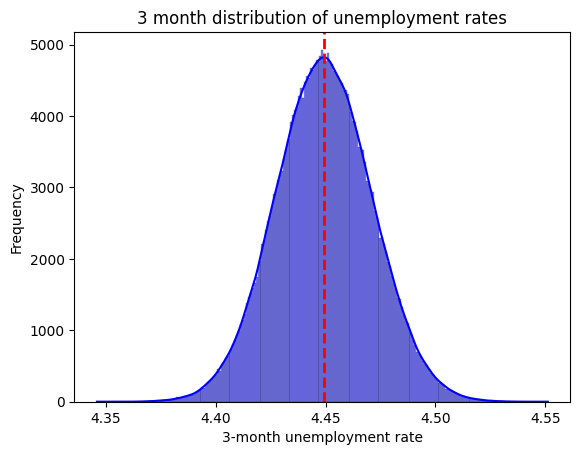

In [ ]:
#50% Forecast
Forecast_percentile=0.50
#X% Forecast
Outcome_50=np.percentile(simulation_result,Forecast_percentile*100)
print(Outcome_50.round(2))
###Visual
sns.histplot(simulation_result,kde=True,color='blue')
plt.xlabel(f'{months}-month unemployment rate')
plt.ylabel('Frequency')
plt.title(f'{months} month distribution of unemployment rates')
plt.axvline(x=Outcome_50,color='red',linestyle='dashed',linewidth=2,label=f'Forecast at{Forecast_percentile*100}%')
plt.legend
plt.show()

4.48


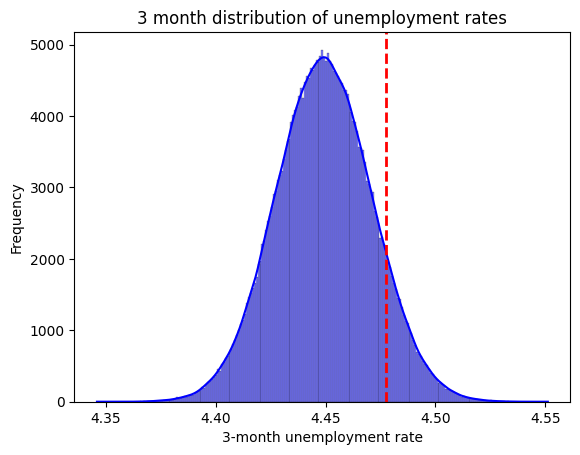

In [ ]:
#90% Forecast
Forecast_percentile=0.90
#X% Forecast
Outcome_90=np.percentile(simulation_result,Forecast_percentile*100)
print(Outcome_90.round(2))
###Visual
sns.histplot(simulation_result,kde=True,color='blue')
plt.xlabel(f'{months}-month unemployment rate')
plt.ylabel('Frequency')
plt.title(f'{months} month distribution of unemployment rates')
plt.axvline(x=Outcome_90,color='red',linestyle='dashed',linewidth=2,label=f'Forecast at{Forecast_percentile*100}%')
plt.legend
plt.show()